## Gradcam RANDOM

 Predicted class probabilities:
Wake (0): 1.0000
N1 (1): 0.0000
N2 (2): 0.0000
N3 (3): 0.0000
REM (4): 0.0000
True label: Wake (0)


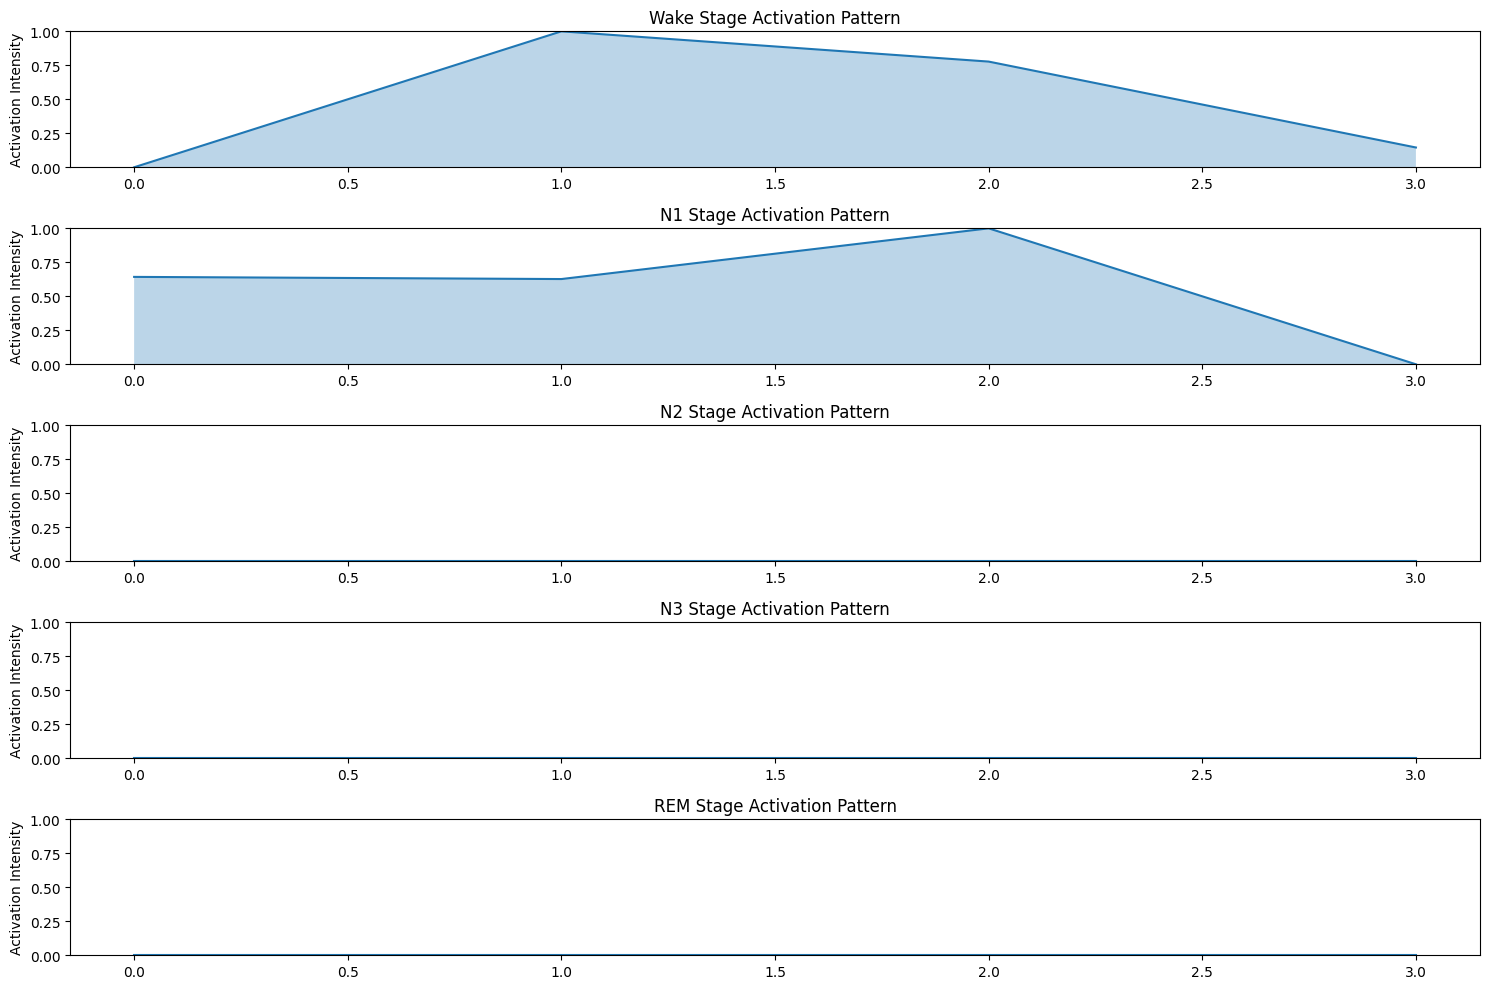

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 모델 로딩
model = MainModel(config)
model.load_state_dict(torch.load("/content/presentable_cnnclassifiermodel.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

In [ ]:
# Grad-CAM 클래스
class MultiClassGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        # 마지막 Conv 레이어 (PReLU 전의 Conv 또는 BatchNorm 등)
        target_layer = self.model.feature.layer4[4]
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output  # shape: (B, C, T)

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # shape: (B, C, T)

    def generate_cam(self, x, target_class):
        self.model.eval()
        self.gradients = None
        self.activations = None

        x = x.to(next(self.model.parameters()).device)
        output = self.model(x)[0]  # (B, T, C)
        pred = output.mean(dim=1)  # (B, C)

        self.model.zero_grad()
        pred[:, target_class].backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=2, keepdim=True)  # (B, C, 1)
        cam = torch.sum(weights * self.activations, dim=1)         # (B, T)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().detach().numpy()
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-5)
        return cam

# 샘플 가져오기
input_batch, label_batch = next(iter(val_loader))  # (B, 2, 3000)
sample_input = input_batch[0].unsqueeze(0).to(device)
true_label = label_batch[0].item()

# 클래스별 확률
with torch.no_grad():
    output = model(sample_input)[0]   # (1, T, C)
    avg_pred = output.mean(dim=1)     # (1, C)
    probs = F.softmax(avg_pred, dim=1)
    probs_np = probs.cpu().numpy().flatten()

# 확률 출력
stage_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
print(" Predicted class probabilities:")
for class_id, prob in enumerate(probs_np):
    print(f"{stage_labels[class_id]} ({class_id}): {prob:.4f}")
print(f"True label: {stage_labels[true_label]} ({true_label})")

# Grad-CAM 생성
cam_generator = MultiClassGradCAM(model)
cams = {}
for class_id in stage_labels:
    cams[class_id] = cam_generator.generate_cam(sample_input, class_id)

# 시각화
plt.figure(figsize=(15, 10))
for idx, (class_id, cam) in enumerate(cams.items()):
    plt.subplot(5, 1, idx + 1)
    plt.plot(cam, label='Activation Map')
    plt.fill_between(range(len(cam)), cam, alpha=0.3)
    plt.title(f'{stage_labels[class_id]} Stage Activation Pattern')
    plt.ylabel('Activation Intensity')
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 각 단계별 gradcam


🎯 True label: N1 (1)
🔮 Predicted: N2 (2)
📊 Class probabilities:
  Wake (0): 0.0008
  N1 (1): 0.3921
  N2 (2): 0.6056
  N3 (3): 0.0004
  REM (4): 0.0011

🎯 True label: N1 (1)
🔮 Predicted: N1 (1)
📊 Class probabilities:
  Wake (0): 0.0022
  N1 (1): 0.9976
  N2 (2): 0.0001
  N3 (3): 0.0000
  REM (4): 0.0001
✅ N1 예측 성공. Grad-CAM 시각화 시작...


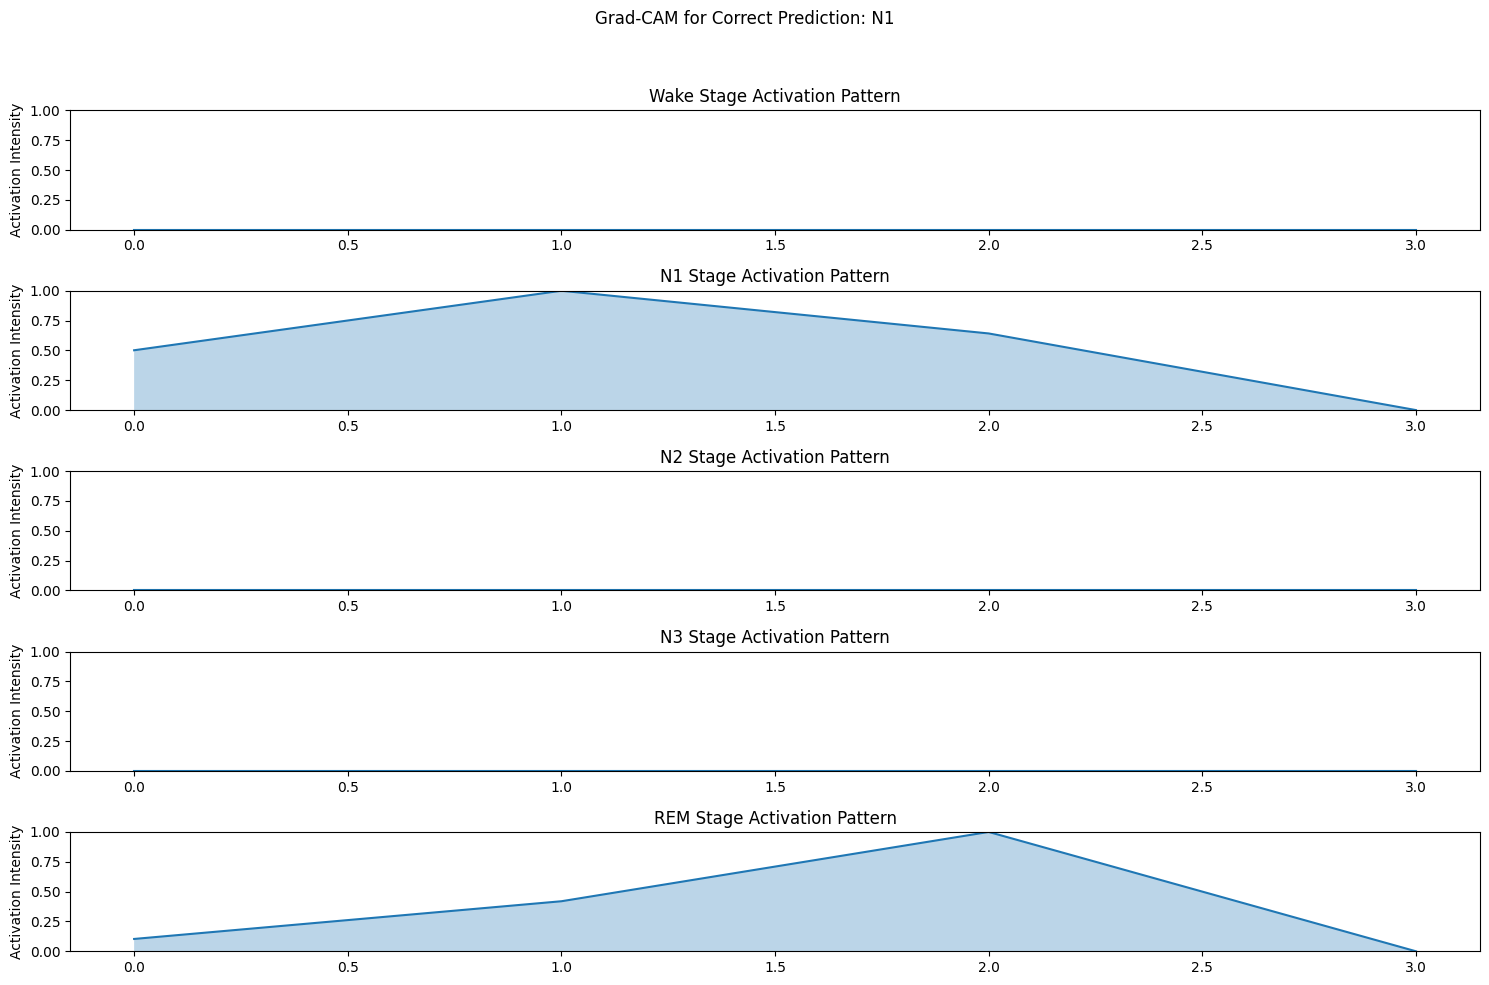

In [ ]:
# N1 단계 : 예측률 낮아서 따로 분리 --> 예측 성공 시까지 반복
target_label = 1  # N1
cam_generator = MultiClassGradCAM(model)
stage_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

found = False

for batch_inputs, batch_labels in val_loader:
    for x, y in zip(batch_inputs, batch_labels):
        if y.item() != target_label:
            continue

        sample_input = x.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(sample_input)[0]     # (1, T, C)
            avg_pred = output.mean(dim=1)       # (1, C)
            probs = F.softmax(avg_pred, dim=1)  # (1, C)
            pred_class = torch.argmax(probs, dim=1).item()
            probs_np = probs.cpu().numpy().flatten()

        print(f"\n🎯 True label: {stage_labels[target_label]} ({target_label})")
        print(f"🔮 Predicted: {stage_labels[pred_class]} ({pred_class})")
        print("📊 Class probabilities:")
        for class_id, prob in enumerate(probs_np):
            print(f"  {stage_labels[class_id]} ({class_id}): {prob:.4f}")

        # 예측이 맞은 경우에만 시각화
        if pred_class == target_label:
            print("✅ N1 예측 성공. Grad-CAM 시각화 시작...")
            cams = {}
            for class_id in stage_labels:
                cams[class_id] = cam_generator.generate_cam(sample_input, class_id)

            plt.figure(figsize=(15, 10))
            for idx, (class_id, cam) in enumerate(cams.items()):
                plt.subplot(5, 1, idx + 1)
                plt.plot(cam, label='Activation Map')
                plt.fill_between(range(len(cam)), cam, alpha=0.3)
                plt.title(f'{stage_labels[class_id]} Stage Activation Pattern')
                plt.ylabel('Activation Intensity')
                plt.ylim(0, 1)
            plt.suptitle(f'Grad-CAM for Correct Prediction: {stage_labels[target_label]}')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

            found = True
            break

    if found:
        break

## N1 제외 나머지 단계 Grad-CAM 구현


🎯 True label: Wake (0)
🔮 Predicted: Wake (0)
📊 Class probabilities:
  Wake (0): 1.0000
  N1 (1): 0.0000
  N2 (2): 0.0000
  N3 (3): 0.0000
  REM (4): 0.0000
✅ Prediction is correct. Visualizing Grad-CAM...


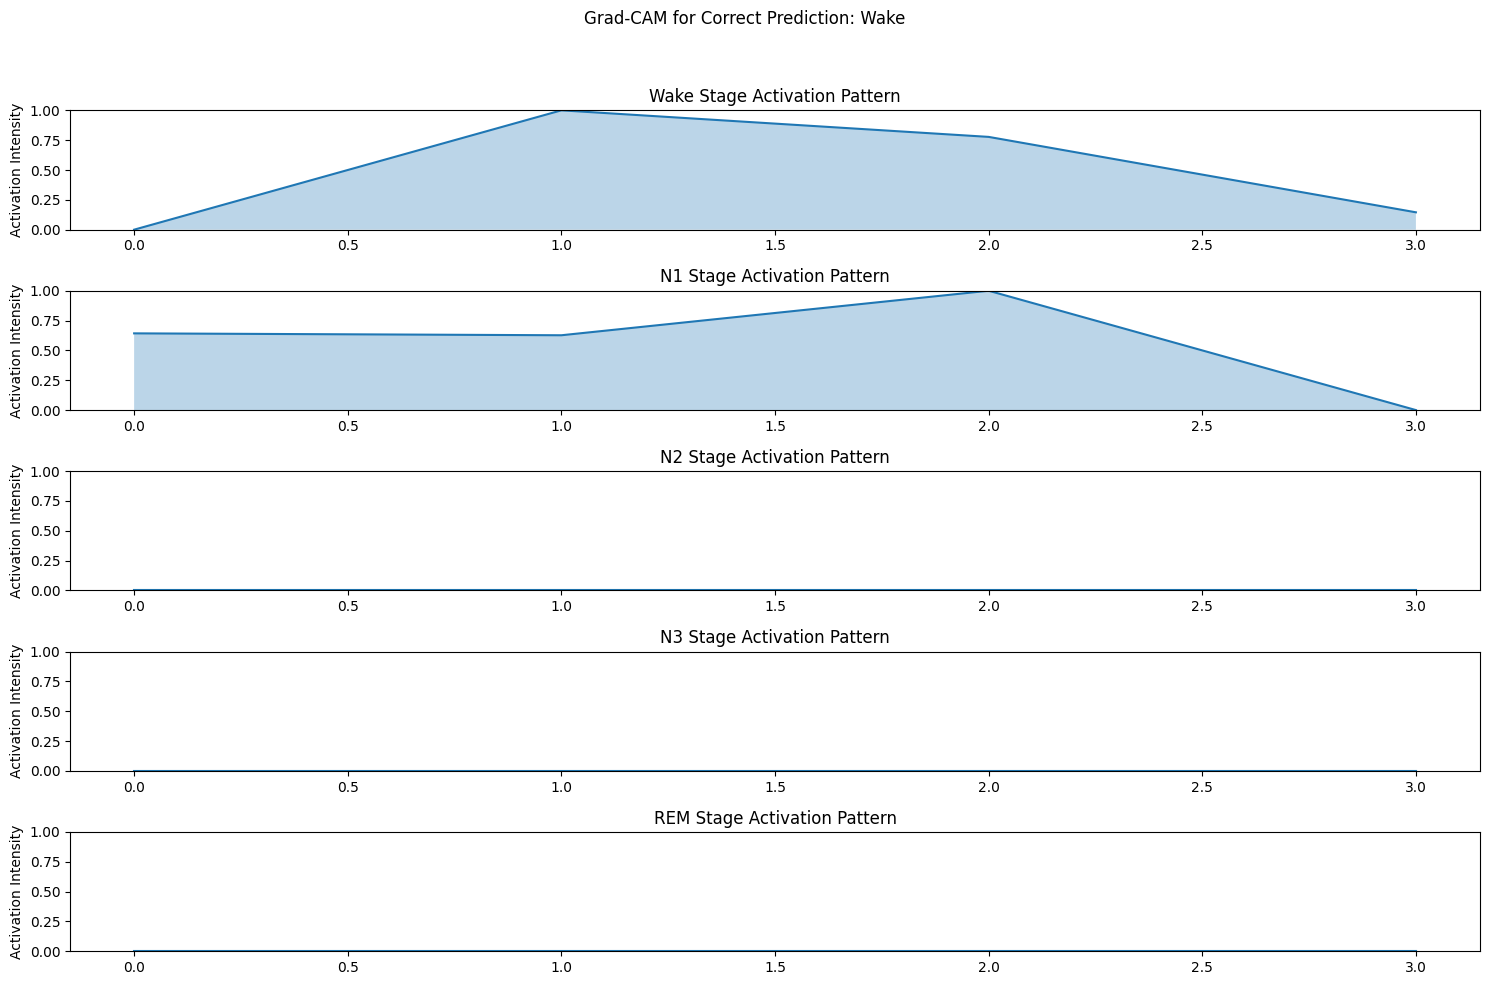


🎯 True label: N1 (1)
🔮 Predicted: N2 (2)
📊 Class probabilities:
  Wake (0): 0.0008
  N1 (1): 0.3921
  N2 (2): 0.6056
  N3 (3): 0.0004
  REM (4): 0.0011
❌ Prediction incorrect. Skipping visualization.

🎯 True label: N2 (2)
🔮 Predicted: N2 (2)
📊 Class probabilities:
  Wake (0): 0.0000
  N1 (1): 0.0003
  N2 (2): 0.9882
  N3 (3): 0.0008
  REM (4): 0.0107
✅ Prediction is correct. Visualizing Grad-CAM...


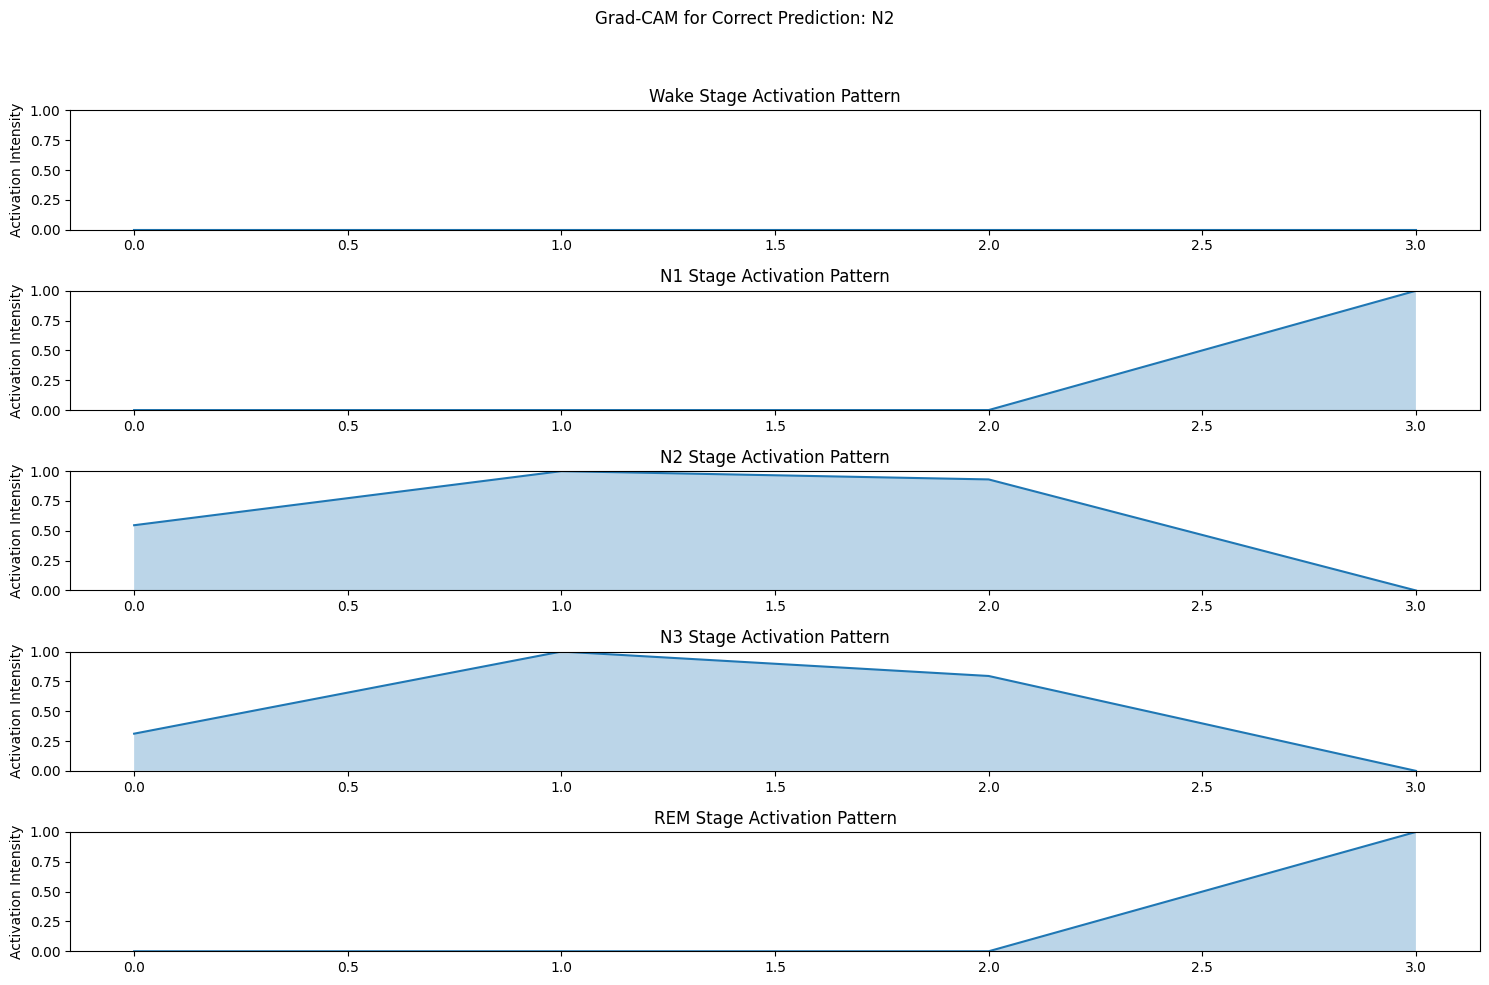


🎯 True label: N3 (3)
🔮 Predicted: N3 (3)
📊 Class probabilities:
  Wake (0): 0.0000
  N1 (1): 0.0000
  N2 (2): 0.0000
  N3 (3): 1.0000
  REM (4): 0.0000
✅ Prediction is correct. Visualizing Grad-CAM...


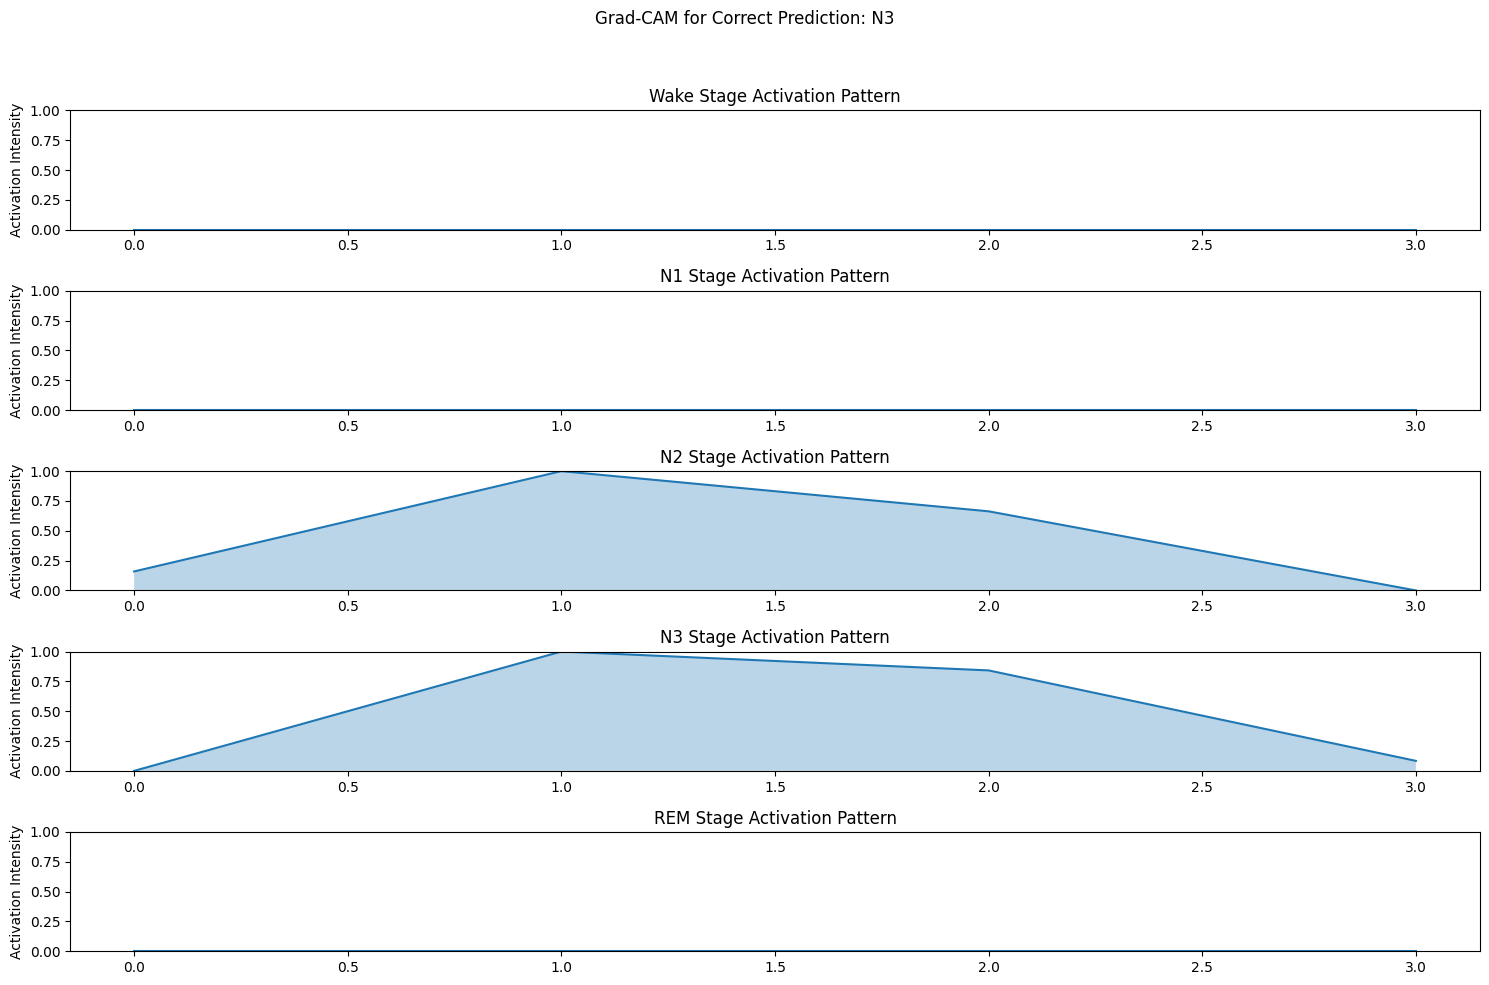


🎯 True label: REM (4)
🔮 Predicted: REM (4)
📊 Class probabilities:
  Wake (0): 0.0000
  N1 (1): 0.0004
  N2 (2): 0.0000
  N3 (3): 0.0000
  REM (4): 0.9996
✅ Prediction is correct. Visualizing Grad-CAM...


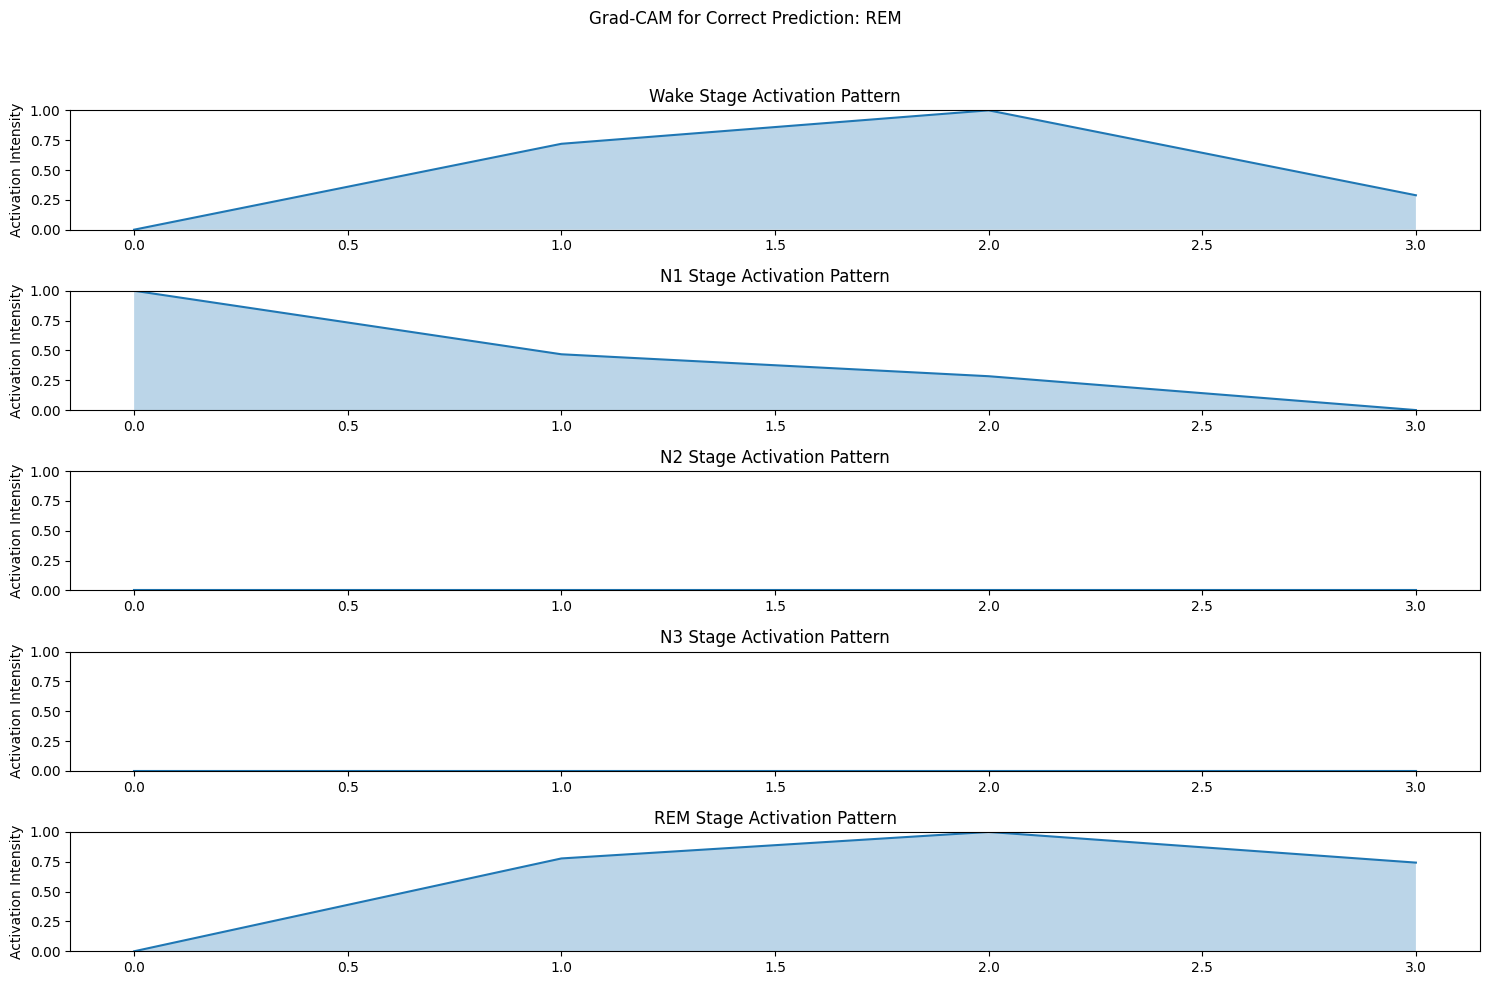

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 모델 로드
model = MainModel(config)
model.load_state_dict(torch.load("/content/presentable_cnnclassifiermodel.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Grad-CAM 클래스
class MultiClassGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer = self.model.feature.layer4[4]
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, x, target_class):
        self.model.eval()
        self.gradients = None
        self.activations = None

        x = x.to(next(self.model.parameters()).device)
        output = self.model(x)[0]  # (B, T, C)
        pred = output.mean(dim=1)  # (B, C)

        self.model.zero_grad()
        pred[:, target_class].backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=2, keepdim=True)  # (B, C, 1)
        cam = torch.sum(weights * self.activations, dim=1)         # (B, T)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().detach().numpy()
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-5)
        return cam

# 샘플 수집
target_labels = {0, 1, 2, 3, 4}
collected_samples = {}

for batch_inputs, batch_labels in val_loader:
    for x, y in zip(batch_inputs, batch_labels):
        label = y.item()
        if label in target_labels and label not in collected_samples:
            collected_samples[label] = x.unsqueeze(0)  # (1, 2, 3000)
        if len(collected_samples) == len(target_labels):
            break
    if len(collected_samples) == len(target_labels):
        break

# 예측 및 Grad-CAM
stage_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
cam_generator = MultiClassGradCAM(model)

for true_label in sorted(collected_samples.keys()):
    sample_input = collected_samples[true_label].to(device)

    with torch.no_grad():
        output = model(sample_input)[0]     # (1, T, C)
        avg_pred = output.mean(dim=1)       # (1, C)
        probs = F.softmax(avg_pred, dim=1)  # (1, C)
        pred_class = torch.argmax(probs, dim=1).item()
        probs_np = probs.cpu().numpy().flatten()

    print(f"\n🎯 True label: {stage_labels[true_label]} ({true_label})")
    print(f"🔮 Predicted: {stage_labels[pred_class]} ({pred_class})")
    print("📊 Class probabilities:")
    for class_id, prob in enumerate(probs_np):
        print(f"  {stage_labels[class_id]} ({class_id}): {prob:.4f}")

    # ✅ 정확히 예측한 경우에만 시각화
    if pred_class == true_label:
        print("✅ Prediction is correct. Visualizing Grad-CAM...")
        cams = {}
        for class_id in stage_labels:
            cams[class_id] = cam_generator.generate_cam(sample_input, class_id)

        plt.figure(figsize=(15, 10))
        for idx, (class_id, cam) in enumerate(cams.items()):
            plt.subplot(5, 1, idx + 1)
            plt.plot(cam, label='Activation Map')
            plt.fill_between(range(len(cam)), cam, alpha=0.3)
            plt.title(f'{stage_labels[class_id]} Stage Activation Pattern')
            plt.ylabel('Activation Intensity')
            plt.ylim(0, 1)
        plt.suptitle(f'Grad-CAM for Correct Prediction: {stage_labels[true_label]}')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    else:
        print("❌ Prediction incorrect. Skipping visualization.")

## Grad-CAM Intensity 오버레이 해석


✅ Correctly predicted stage: Wake
🔍 Template: 🔹 알파파 (8–13Hz) 고주파 패턴


<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 50508 (\N{HANGUL SYLLABLE AL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 54056 (\N{HANGUL SYLLABLE PAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 53556 (\N{HANGUL SYLLABLE TEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/u

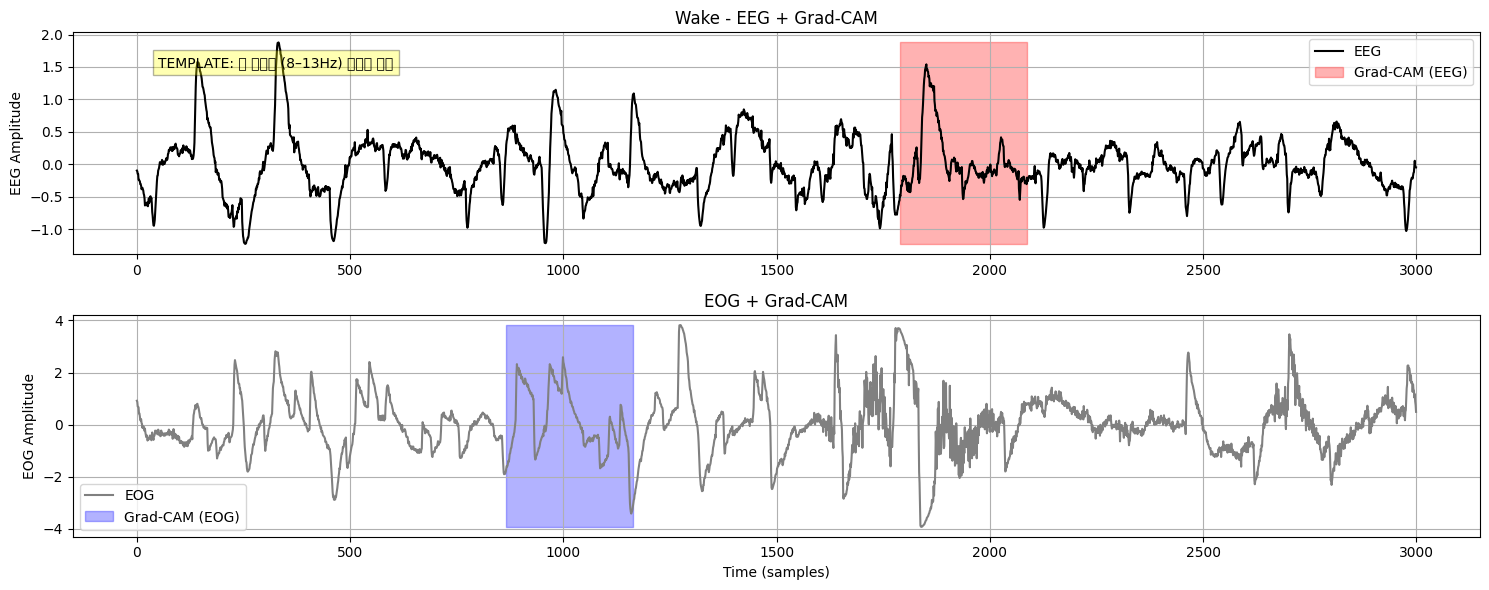

❌ Skipping: Prediction incorrect (N1)

✅ Correctly predicted stage: N2
🔍 Template: 🔹 K-complex 및 Sleep spindle (burst)


<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


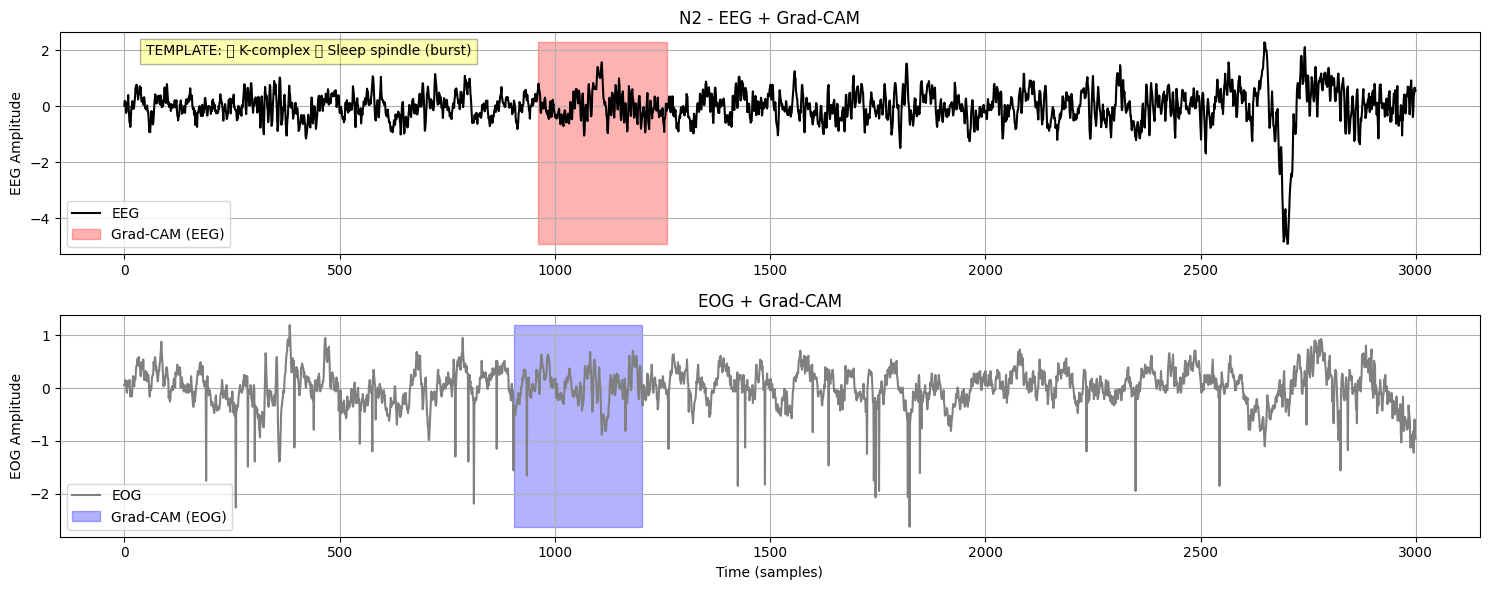


✅ Correctly predicted stage: N3
🔍 Template: 🔹 전반적 느린 델타파 (0.5–2Hz)


<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 47536 (\N{HANGUL SYLLABLE RIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

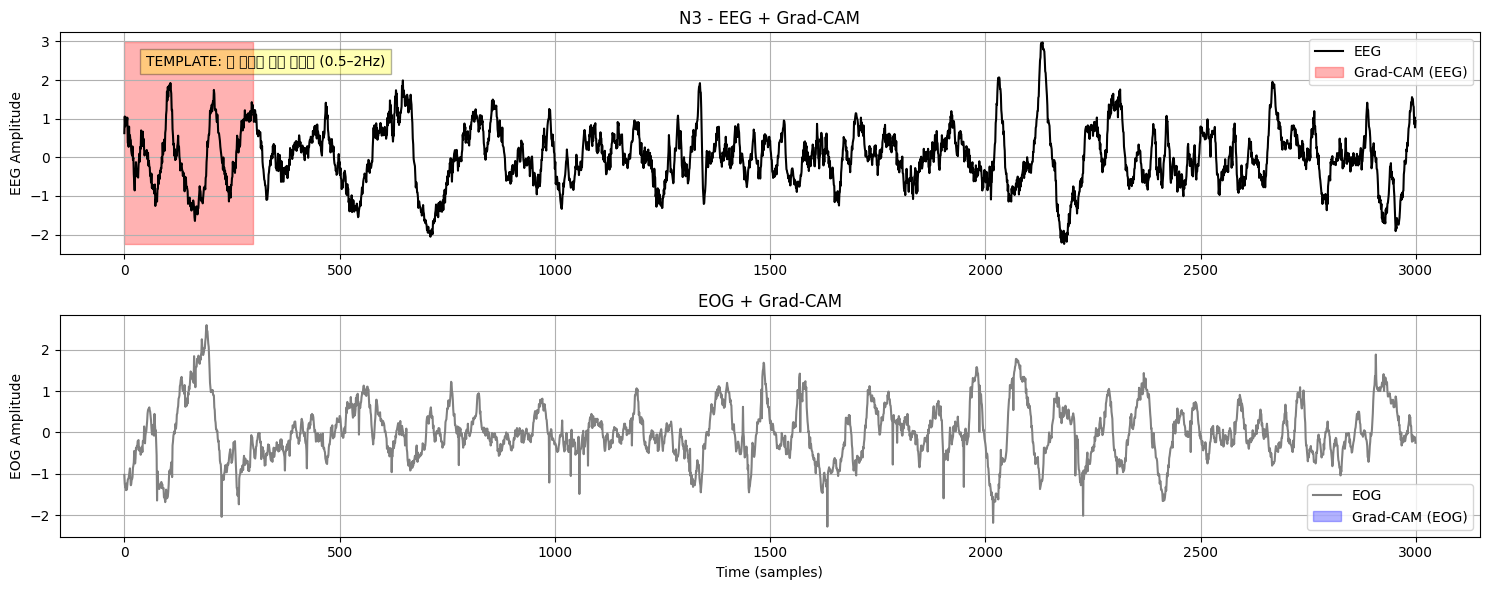


✅ Correctly predicted stage: REM
🔍 Template: 🔹 빠른 안구 움직임 (EOG 강조), EEG 불규칙


<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 48736 (\N{HANGUL SYLLABLE BBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 50880 (\N{HANGUL SYLLABLE UM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 51649 (\N{HANGUL SYLLABLE JIG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c843c9bba7e4>:114: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<i

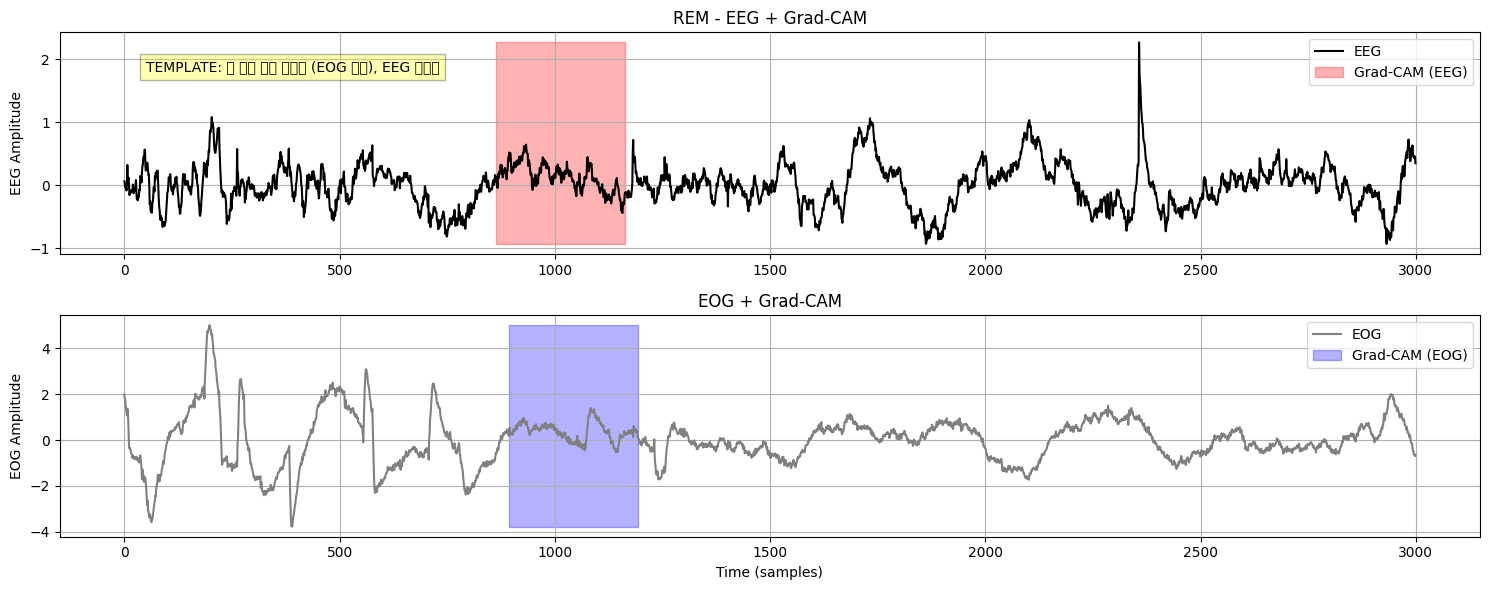

In [ ]:
# (1) 모델 정의 및 로딩
model = MainModel(config)
model.load_state_dict(torch.load("/content/presentable_cnnclassifiermodel.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 단계 이름 및 템플릿 설명
stage_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
stage_templates = {
    0: "🔹 알파파 (8–13Hz) 고주파 패턴",
    1: "🔹 Sleep vertex wave 또는 느린 델타 시작",
    2: "🔹 K-complex 및 Sleep spindle (burst)",
    3: "🔹 전반적 느린 델타파 (0.5–2Hz)",
    4: "🔹 빠른 안구 움직임 (EOG 강조), EEG 불규칙"
}

# Grad-CAM 클래스 정의 (MultiClassGradCAM)
class MultiClassGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer = self.model.feature.layer4[2]  # 더 마지막 ConvBlock 조정 가능
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, x, target_class):
        self.model.eval()
        self.gradients = None
        self.activations = None
        x = x.to(next(self.model.parameters()).device)
        output = self.model(x)[0]  # (B, T, C)
        pred = output.mean(dim=1)  # (B, C)
        self.model.zero_grad()
        pred[:, target_class].backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=2, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = F.relu(cam).squeeze().cpu().detach().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) + 1e-5)
        return cam
# visualize_with_template 함수 정의

def visualize_with_template(sample_input, true_label, model):
    device = next(model.parameters()).device
    sample_input = sample_input.to(device)

    with torch.no_grad():
        output = model(sample_input)[0]     # (1, T, C)
        avg_pred = output.mean(dim=1)
        probs = F.softmax(avg_pred, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    if pred_class != true_label:
        print(f"❌ Skipping: Prediction incorrect ({stage_labels[true_label]})")
        return

    print(f"\n Correctly predicted stage: {stage_labels[true_label]}")
    print("Template:", stage_templates[true_label])

    cam_generator = MultiClassGradCAM(model)

    eeg_only = sample_input.clone(); eeg_only[:, 1, :] = 0
    eog_only = sample_input.clone(); eog_only[:, 0, :] = 0

    eeg_cam = cam_generator.generate_cam(eeg_only, true_label)
    eog_cam = cam_generator.generate_cam(eog_only, true_label)

    eeg_signal = sample_input[0, 0, :].cpu().numpy()
    eog_signal = sample_input[0, 1, :].cpu().numpy()
    time = np.arange(len(eeg_signal))

    # CAM 보간 (eeg_cam 길이 → 3000으로 맞춤)
    eeg_cam_resized = np.interp(np.linspace(0, 1, len(eeg_signal)),
                                np.linspace(0, 1, len(eeg_cam)),
                                eeg_cam)
    eog_cam_resized = np.interp(np.linspace(0, 1, len(eog_signal)),
                                np.linspace(0, 1, len(eog_cam)),
                                eog_cam)

    eeg_mask = eeg_cam_resized > np.percentile(eeg_cam_resized, 90)
    eog_mask = eog_cam_resized > np.percentile(eog_cam_resized, 90)

    # 시각화
    plt.figure(figsize=(15, 6))

    # EEG 시각화
    plt.subplot(2, 1, 1)
    plt.plot(time, eeg_signal, label="EEG", color='black')
    plt.fill_between(time, np.min(eeg_signal), np.max(eeg_signal), where=eeg_mask, color='red', alpha=0.3, label="Grad-CAM (EEG)")
    plt.title(f"{stage_labels[true_label]} - EEG + Grad-CAM")
    #plt.text(50, np.max(eeg_signal)*0.8, f"TEMPLATE: {stage_templates[true_label]}", fontsize=10, bbox=dict(facecolor='yellow', alpha=0.3))
    plt.ylabel("EEG Amplitude")
    plt.grid(True)
    plt.legend()

    # EOG 시각화
    plt.subplot(2, 1, 2)
    plt.plot(time, eog_signal, label="EOG", color='gray')
    plt.fill_between(time, np.min(eog_signal), np.max(eog_signal), where=eog_mask, color='blue', alpha=0.3, label="Grad-CAM (EOG)")
    plt.title("EOG + Grad-CAM")
    plt.xlabel("Time (samples)")
    plt.ylabel("EOG Amplitude")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 수면 단계별로 정확히 하나씩 샘플 수집
target_labels = {0, 1, 2, 3, 4}
collected_samples = {}
for batch_inputs, batch_labels in val_loader:
    for x, y in zip(batch_inputs, batch_labels):
        label = y.item()
        if label in target_labels and label not in collected_samples:
            collected_samples[label] = x.unsqueeze(0)
        if len(collected_samples) == len(target_labels):
            break
    if len(collected_samples) == len(target_labels):
        break

# 정확히 예측된 샘플만 시각화
for true_label in sorted(collected_samples.keys()):
    sample_input = collected_samples[true_label]
    visualize_with_template(sample_input, true_label, model)


## Sleep Stage W/STFT 변환 그래프

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
import gc

# 모델 로드
model = MainModel(config)
model.load_state_dict(torch.load("/content/presentable_cnnclassifiermodel.pt"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# 수면 단계 라벨 및 각 수면단계 설명
stage_labels = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
stage_templates = {
    0: "알파파 (8–13Hz) 고주파 패턴",
    1: "Sleep vertex wave 또는 느린 델타 시작",
    2: "K-complex 및 Sleep spindle (burst)",
    3: "전반적 느린 델타파 (0.5–2Hz)",
    4: "빠른 안구 움직임 (EOG 강조), EEG 불규칙"
}

# Grad-CAM 정의
class MultiClassGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer = self.model.feature.layer4[2]
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, x, target_class):
        self.model.eval()
        self.gradients = None
        self.activations = None
        x = x.to(next(self.model.parameters()).device)
        output = self.model(x)[0]
        pred = output.mean(dim=1)
        self.model.zero_grad()
        pred[:, target_class].backward(retain_graph=True)
        weights = torch.mean(self.gradients, dim=2, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = F.relu(cam).squeeze().cpu().detach().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) + 1e-5)
        return cam

# STFT 시각화
def plot_stft_subplot(eeg_signal, eog_signal, fs=100, label=None):
    f_eeg, t_eeg, Zxx_eeg = stft(eeg_signal, fs=fs, nperseg=fs*2)
    f_eog, t_eog, Zxx_eog = stft(eog_signal, fs=fs, nperseg=fs*2)

    plt.subplot(2, 2, 3)
    plt.pcolormesh(t_eeg, f_eeg, np.abs(Zxx_eeg), shading='gouraud', cmap='magma')
    if label == 0:
        plt.axhspan(8, 13, color='cyan', alpha=0.3, label="Alpha (8–13 Hz)")
    elif label == 3:
        plt.axhspan(0.5, 2.0, color='orange', alpha=0.3, label="Delta (0.5–2 Hz)")
    plt.title("EEG STFT")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, 20)
    plt.colorbar(label="Amplitude")
    if label in [0, 3]:
        plt.legend()

    plt.subplot(2, 2, 4)
    plt.pcolormesh(t_eog, f_eog, np.abs(Zxx_eog), shading='gouraud', cmap='magma')
    if label == 0:
        plt.axhspan(8, 13, color='cyan', alpha=0.3, label="Alpha (8–13 Hz)")
    elif label == 3:
        plt.axhspan(0.5, 2.0, color='orange', alpha=0.3, label="Delta (0.5–2 Hz)")
    plt.title("EOG STFT")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, 20)
    plt.colorbar(label="Amplitude")
    if label in [0, 3]:
        plt.legend()

# 통합 시각화 함수
def full_visualization_stft(sample_input, true_label, model, fs=100):
    device = next(model.parameters()).device
    sample_input = sample_input.to(device)

    with torch.no_grad():
        output = model(sample_input)[0]
        avg_pred = output.mean(dim=1)
        probs = F.softmax(avg_pred, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    if pred_class != true_label:
        return False

    print(f"\n Correctly predicted stage: {stage_labels[true_label]}")
    print(" Template:", stage_templates[true_label])

    cam_generator = MultiClassGradCAM(model)
    eeg_only = sample_input.clone(); eeg_only[:, 1, :] = 0
    eog_only = sample_input.clone(); eog_only[:, 0, :] = 0

    eeg_cam = cam_generator.generate_cam(eeg_only, true_label)
    eog_cam = cam_generator.generate_cam(eog_only, true_label)

    eeg_signal = sample_input[0, 0, :].cpu().numpy()
    eog_signal = sample_input[0, 1, :].cpu().numpy()
    time = np.arange(len(eeg_signal))

    eeg_cam_resized = np.interp(np.linspace(0, 1, len(eeg_signal)),
                                np.linspace(0, 1, len(eeg_cam)), eeg_cam)
    eog_cam_resized = np.interp(np.linspace(0, 1, len(eog_signal)),
                                np.linspace(0, 1, len(eog_cam)), eog_cam)

    eeg_mask = eeg_cam_resized > np.percentile(eeg_cam_resized, 90)
    eog_mask = eog_cam_resized > np.percentile(eog_cam_resized, 90)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(time, eeg_signal, label="EEG", color='black')
    plt.fill_between(time, np.min(eeg_signal), np.max(eeg_signal), where=eeg_mask, color='red', alpha=0.3, label="Grad-CAM (EEG)")
    plt.title(f"{stage_labels[true_label]} - EEG + Grad-CAM")
    #plt.text(50, np.max(eeg_signal)*0.8, f"TEMPLATE: {stage_templates[true_label]}", fontsize=10, bbox=dict(facecolor='yellow', alpha=0.3))
    plt.ylabel("EEG Amplitude")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(time, eog_signal, label="EOG", color='gray')
    plt.fill_between(time, np.min(eog_signal), np.max(eog_signal), where=eog_mask, color='blue', alpha=0.3, label="Grad-CAM (EOG)")
    plt.title("EOG + Grad-CAM")
    plt.xlabel("Time (samples)")
    plt.ylabel("EOG Amplitude")
    plt.grid(True)
    plt.legend()

    plot_stft_subplot(eeg_signal, eog_signal, fs, label=true_label)

    plt.tight_layout()
    plt.show()
    plt.close()
    return True

# 샘플 수집
target_labels = {0, 1, 2, 3, 4}
collected_samples = {}
for batch_inputs, batch_labels in val_loader:
    for x, y in zip(batch_inputs, batch_labels):
        label = y.item()
        if label in target_labels and label not in collected_samples:
            collected_samples[label] = x.unsqueeze(0)
        if len(collected_samples) == len(target_labels):
            break
    if len(collected_samples) == len(target_labels):
        break

# Wake, N2, N3, REM 단계 시각화
for true_label in [0, 2, 3, 4]:
    sample_input = collected_samples[true_label]
    _ = full_visualization_stft(sample_input, true_label, model)
    torch.cuda.empty_cache()
    gc.collect()

# N1 단계는 맞을 때까지 반복 탐색
found = False
for batch_inputs, batch_labels in val_loader:
    for x, y in zip(batch_inputs, batch_labels):
        if y.item() == 1:
            success = full_visualization_stft(x.unsqueeze(0), 1, model)
            torch.cuda.empty_cache()
            gc.collect()
            if success:
                found = True
                break
    if found:
        break

## Sleep Spindle, K-Complex Detector

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import gc

# Bandpass Filter
def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

# Spindle Detector (특징에 맞춰 구성)
def detect_spindles(eeg, fs=100, rms_window=0.2, threshold_factor=1.5):
    filtered = bandpass_filter(eeg, fs, 12, 15)
    rms = np.sqrt(np.convolve(filtered ** 2, np.ones(int(rms_window * fs)) / int(rms_window * fs), mode='same'))
    threshold = np.mean(rms) + threshold_factor * np.std(rms)
    above = rms > threshold
    spindles = []
    i = 0
    while i < len(above):
        if above[i]:
            start = i
            while i < len(above) and above[i]:
                i += 1
            duration = (i - start) / fs
            if 0.5 <= duration <= 2.0:
                spindles.append((start / fs + 0.5 * rms_window))
        else:
            i += 1
    return spindles

# K-complex Detector
def detect_k_complexes(eeg, fs=100, amp_threshold=1.0):
    slow_wave = bandpass_filter(eeg, fs, 0.5, 2.0)
    analytic = hilbert(slow_wave)
    envelope = np.abs(analytic)
    k_complexes = []
    window_size = int(1.0 * fs)
    for i in range(0, len(envelope) - window_size, window_size // 2):
        segment = slow_wave[i:i+window_size]
        if np.ptp(segment) > amp_threshold:
            k_complexes.append((i + window_size // 2) / fs)
    return k_complexes


# Grad-CAM 클래스 정의
class MultiClassGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer = self.model.feature.layer4[2]
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, x, target_class):
        self.model.eval()
        self.gradients = None
        self.activations = None
        x = x.to(next(self.model.parameters()).device)
        output = self.model(x)[0]
        pred = output.mean(dim=1)
        self.model.zero_grad()
        pred[:, target_class].backward(retain_graph=True)
        weights = torch.mean(self.gradients, dim=2, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = F.relu(cam).squeeze().cpu().detach().numpy()
        cam = (cam - np.min(cam)) / (np.max(cam) + 1e-5)
        return cam

# 시각화 함수 정의
def full_visualization_n2_with_detections(sample_input, true_label, model, fs=100):
    device = next(model.parameters()).device
    sample_input = sample_input.to(device)

    with torch.no_grad():
        output = model(sample_input)[0]
        avg_pred = output.mean(dim=1)
        probs = F.softmax(avg_pred, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    if pred_class != true_label or true_label != 2:
        return False

    eeg_signal = sample_input[0, 0, :].cpu().numpy()
    eog_signal = sample_input[0, 1, :].cpu().numpy()
    time = np.arange(len(eeg_signal))

    spindle_times = detect_spindles(eeg_signal, fs=fs)
    kcomplex_times = detect_k_complexes(eeg_signal, fs=fs)

    print(f"\n Correctly predicted stage: N2")
    print("Template: K-complex 및 Sleep spindle (burst)")
    print("Detected Spindles:", np.round(spindle_times, 2))
    print("Detected K-complexes:", np.round(kcomplex_times, 2))

    cam_generator = MultiClassGradCAM(model)
    eeg_only = sample_input.clone(); eeg_only[:, 1, :] = 0
    eog_only = sample_input.clone(); eog_only[:, 0, :] = 0
    eeg_cam = cam_generator.generate_cam(eeg_only, true_label)
    eog_cam = cam_generator.generate_cam(eog_only, true_label)

    eeg_cam_resized = np.interp(np.linspace(0, 1, len(eeg_signal)),
                                np.linspace(0, 1, len(eeg_cam)), eeg_cam)
    eog_cam_resized = np.interp(np.linspace(0, 1, len(eog_signal)),
                                np.linspace(0, 1, len(eog_cam)), eog_cam)

    eeg_mask = eeg_cam_resized > np.percentile(eeg_cam_resized, 90)
    eog_mask = eog_cam_resized > np.percentile(eog_cam_resized, 90)

    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, eeg_signal, label="EEG", color='black')
    plt.fill_between(time, np.min(eeg_signal), np.max(eeg_signal), where=eeg_mask, color='red', alpha=0.3, label="Grad-CAM (EEG)")
    for t in spindle_times:
        plt.axvline(t * fs, color='blue', linestyle='--', label='Spindle' if t == spindle_times[0] else "")
    for t in kcomplex_times:
        plt.axvline(t * fs, color='orange', linestyle='--', label='K-complex' if t == kcomplex_times[0] else "")
    plt.title("EEG + CAM + Spindle/K-complex Detection")
    plt.ylabel("EEG Amplitude")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time, eog_signal, label="EOG", color='gray')
    plt.fill_between(time, np.min(eog_signal), np.max(eog_signal), where=eog_mask, color='blue', alpha=0.3, label="Grad-CAM (EOG)")
    plt.title("EOG + Grad-CAM")
    plt.xlabel("Time (samples)")
    plt.ylabel("EOG Amplitude")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

## N2 단계 Sleep Spindle, K-Compex 추출


✅ Correctly predicted stage: N2
🔍 Template: K-complex 및 Sleep spindle (burst)
🧠 Detected Spindles: [1.05 3.91]
🧠 Detected K-complexes: [ 3.   3.5  4.   4.5  5.   5.5  6.   9.   9.5 10.  10.5 24.5 25.  25.5
 26.5 27. ]


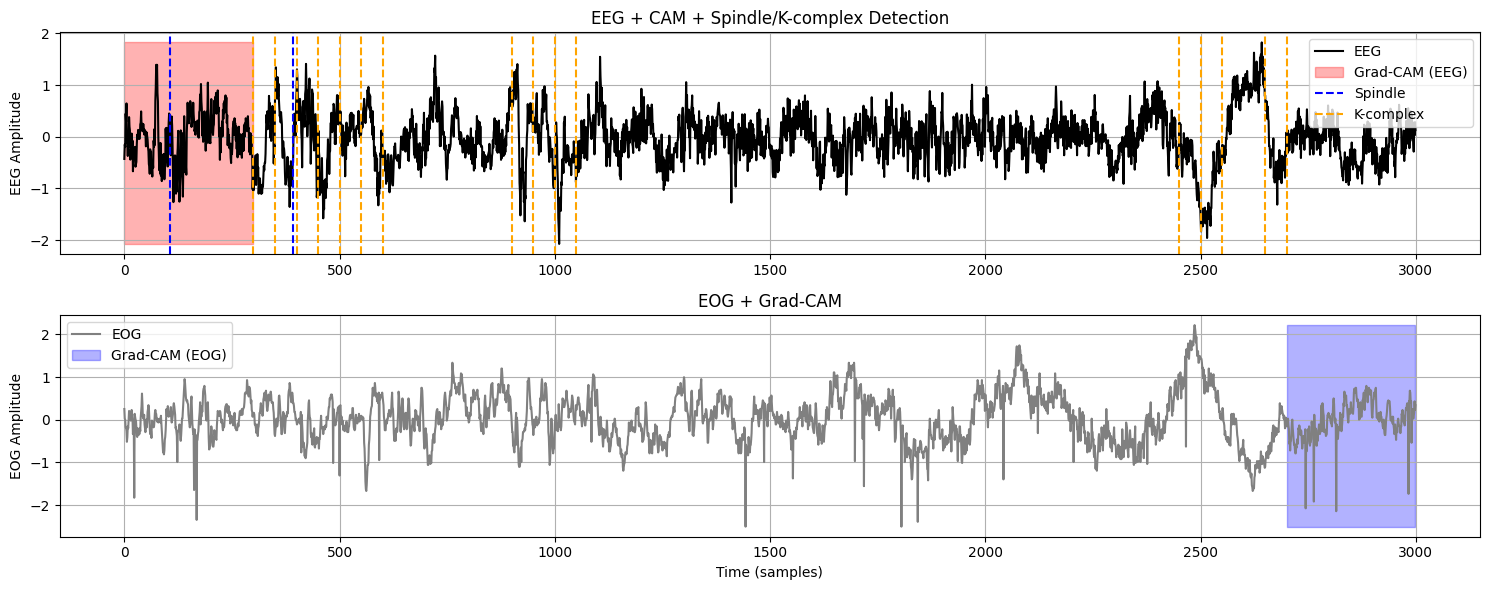

In [ ]:
n2_sample = collected_samples[2]
_ = full_visualization_n2_with_detections(n2_sample, 2, model)
